**Objective**

This script reads raw text content of the documents from a pickle file and cleans up this text using standard operations specific to the **Arabic** language and to this corpus. Pre-exploration of the corpus helps determine those specificities.

The preprocessing pipeline is as follows:

1. Orthographic normalization (remove diacritic marks and tatwil character; normalize different forms of alif character)
2. Tokenization (remove non-word characters and convert to sequence of words)
3. Light stemming based on common prefixes and suffixes (**TO DO**)
4. remove stopwords
5. remove one-character and two-character tokens

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import re
from collections import Counter
from collections import defaultdict

In [3]:
import pickle

In [4]:
import arabic_reshaper
from bidi.algorithm import get_display

## Read data files
- meta data
- raw corpus text
- special vocabulary list

###  raw text data and metadata

In [5]:
with open('../pickle_files/doc_parsed_data.pickle', 'rb') as f:
    doc_data_df = pickle.load(f)
type(doc_data_df),doc_data_df.shape

(pandas.core.frame.DataFrame, (39, 9))

In [6]:
doc_data_df.head()

,hyperlink,filename,author,source,title_arabic,title_latin_translit,tags,section_titles,raw_text
0,http://saramusik.org/5/textei/,5.txt,يعقوب بن إسحاق الكندي,[بريطانيا العظمى],رسالة في خبر صناعة التّأليف,risāla fī ẖabar ṣināʿat al-taʾlīf,"[الموسيقى والفلسفة, المدرسة الأفلاطونيّة المتج...","[1 , تبيا, النّغم المتشابه في الكيفيّة, تمثيل ...",[بالاعتماد على تحقيق يوسف شوقي.]\n[الرّسالة من...
1,http://saramusik.org/6/textei/,6.txt,يعقوب بن إسحاق الكندي,[بريطانيا العظمى],كتاب المصوّتات الوتريّة من ذات الوتر الواحد إل...,kitāb al-muṣawwiṭāt al-watariyya min ḍāt al-wa...,"[الموسيقى والفلسفة, المدرسة الأفلاطونيّة المتج...",[لمقالة الأولى : في ذكر الآلات الصّوتيّة وسائر...,[اعتمادا على تحقيق زكريّا يوسف]\n\nأَطَالَ الَ...
2,http://saramusik.org/7/textei/,7.txt,يعقوب بن إسحاق الكندي,"[ألمانيا, تونس, ألمانيا]",رسالة في أجزاء خبريّة في الموسيقى,risāla fī aǧzāʾ ẖabariyya fī al-mūsīqā,[المدرسة الأفلاطونيّة المتجدّدة],"[مقدّمة, لمقالة الأول, لمقالة الثّاني, لمقالة ...",أنار إليه من خفيّات الأمور بموضحات الرّسوم أفض...
3,http://saramusik.org/9/textei/,9.txt,يعقوب بن إسحاق الكندي,"[ألمانيا, تركيا, ألمانيا]",رسالة الكندي في اللّحون والنّغم,Risālat al-kindī fī al-luhūn wa al-naġam,[المدرسة الأفلاطونيّة المتجدّدة],"[مقدّمة, لفنّ الأوّل : [في تركيب العود وقسمة ا...",بِسْمِ اللَّهِ الرَّحْمَانِ الرَّحِيمِ\nوَمَا ...
4,http://saramusik.org/10/textei/,10.txt,صفي الدّين عبد المؤمن أبو يوسف بن فخر الأرموي,"[تونس, تونس, نمسا, سعوديّة, مصر, مصر, مصر, مصر...",كتاب الأدوار,Kitāb al-Adwār,"[نظريّات موسيقيّة, المدرسة الأرمويّة]","[مقدّمة, ِي تَعْرِيفِ النَّغَمِ وَبَيَانِ الحِ...",الدَّسَاتِينُ هِيَ عَلَامَاتٌ تُوضَعُ عَلَى سَ...


### Special vocabulary words

Words that will be preprocessed in a special way.

In [7]:
special_words_list =[]
with open('../resources/special_vocabulary.txt', 'r', encoding='utf8') as f:
    for line in f:
        special_words_list.append(line.strip())
len(special_words_list)

18

In [8]:
special_words_list

['اصفهان',
 'حجاز',
 'راست',
 'زركشي',
 'زروكند',
 'زنكلاه',
 'شهناز',
 'عراق',
 'نيروز',
 'بزرك',
 'سلمك',
 'كوشت',
 'ماياه',
 'نوى',
 'أبوسليك',
 'عشاق',
 'حسيني',
 'رهاوي']

****

## Exploratory analysis of raw corpus

### Corpus character set

What are the characters in this corpus and how frequently do they occur.

#### Overview of character set

In [9]:
from nltk import FreqDist

In [10]:
def analyze_corpus_charset(corpus):
    fdist = FreqDist([c for doc in corpus for c in doc])

    corpus_chars_df = pd.DataFrame(fdist.items())
    corpus_chars_df.columns = ['character','frequency']
    corpus_chars_df['unicode_dec']= corpus_chars_df.character.map(ord)
    corpus_chars_df['unicode_hex']= corpus_chars_df.character.map(lambda x: hex(ord(x)))
    corpus_chars_df = corpus_chars_df.set_index('character')

    idx1= (corpus_chars_df.unicode_hex.map(len)==5) & (corpus_chars_df.unicode_hex.str.startswith('0x64')|corpus_chars_df.unicode_hex.str.startswith('0x65'))
    idx2 = (corpus_chars_df.unicode_hex.str.startswith('0xfb') | corpus_chars_df.unicode_hex.str.startswith('0xfc') | corpus_chars_df.unicode_hex.str.startswith('0xfd') | corpus_chars_df.unicode_hex.str.startswith('0xfe')) & (corpus_chars_df.unicode_hex.map(len)==6)

    print("number of characters: ", fdist.N())
    print("number of distinct characters: ", fdist.B())
    print("Number of characters from the Standard Arabic character set: %d" %idx1.sum())

    print('List of distinct characters:')
    print(sorted(list(fdist.keys())))

    print('The 20 most common characters:')
    print(fdist.most_common(20))

    print('The 20 least common characters:')
    print(fdist.most_common()[-20:])

    fdist.plot(20, cumulative=True)

    return corpus_chars_df

number of characters:  542130
number of distinct characters:  128
Number of characters from the Standard Arabic character set: 22
List of distinct characters:
['\t', '\n', ' ', '!', '"', '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '>', 'N', '[', ']', 'e', 'n', 'o', '{', '}', '~', '\xa0', '¦', '«', '»', 'έ', 'γ', 'ν', 'ο', 'ς', 'ג', 'ד', 'ה', 'ז', 'ח', 'כ', 'ן', '،', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ٓ', 'ٔ', 'ٕ', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٬', '٭', 'ٱ', 'ە', '۟', '۴', '۵', '۶', '\u200f', '‘', '’', '“', '”', '…', '\u2028', '\u202c', '\u202e', '❊']
The 20 most common characters:
[(' ', 82207), ('ا', 49313), ('ل', 41807), ('َ', 31558), ('ي', 22936), ('و', 22492), ('ن', 22113), ('م', 21927), ('ِ', 15484), ('ر', 14677), ('ه

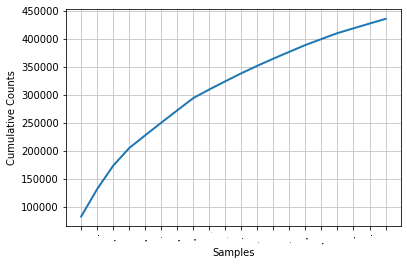

In [11]:
raw_corpus_chars_df = analyze_corpus_charset(doc_data_df.raw_text)

In [12]:
# Standard arabic characters

idx= (raw_corpus_chars_df.unicode_hex.map(len)==5) & (raw_corpus_chars_df.unicode_hex.str.startswith('0x64')|raw_corpus_chars_df.unicode_hex.str.startswith('0x65'))
print(idx.sum())
raw_corpus_chars_df[idx].sort_values(by='unicode_hex')

22


,frequency,unicode_dec,unicode_hex
character,,,
ـ,2803,1600,0x640
ف,10736,1601,0x641
ق,8138,1602,0x642
ك,8144,1603,0x643
ل,41807,1604,0x644
م,21927,1605,0x645
ن,22113,1606,0x646
ه,14295,1607,0x647
و,22492,1608,0x648


#### Frequency distribution of characters

What are the rare and non-rare characters in this corpus.

In [13]:
raw_corpus_chars_df.head()

,frequency,unicode_dec,unicode_hex
character,,,
[,580,91,0x5b
ب,13448,1576,0x628
ا,49313,1575,0x627
ل,41807,1604,0x644
ع,12075,1593,0x639


In [14]:
raw_corpus_chars_df.frequency.describe()

count      128.000000
mean      4235.390625
std      10441.276488
min          1.000000
25%         17.000000
50%         94.500000
75%       3374.500000
max      82207.000000
Name: frequency, dtype: float64

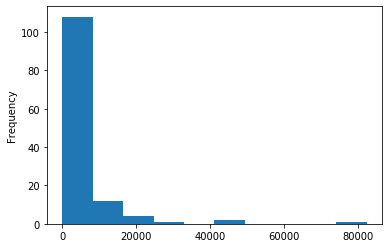

In [15]:
raw_corpus_chars_df.frequency.plot.hist()

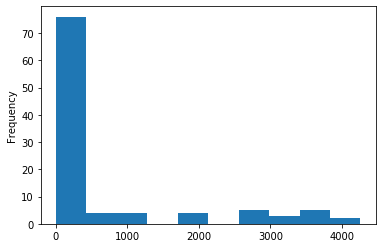

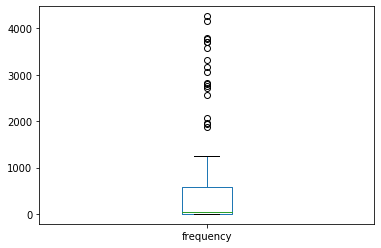

In [16]:
idx = raw_corpus_chars_df.frequency<=5000
raw_corpus_chars_df.loc[idx,'frequency'].plot.hist()
plt.show()
raw_corpus_chars_df.loc[idx,'frequency'].plot.box()

70 58


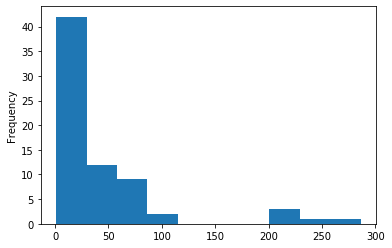

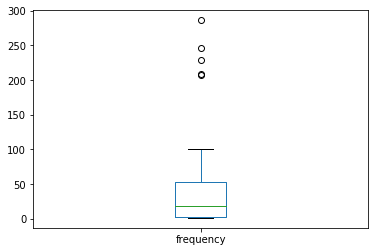

In [17]:
idx = raw_corpus_chars_df.frequency<=300
print(idx.sum(),(~idx).sum())

raw_corpus_chars_df.loc[idx,'frequency'].plot.hist()
plt.show()
raw_corpus_chars_df.loc[idx,'frequency'].plot.box()

In [18]:
# separate rare and non-rare characters
# frequency threshold of 150 was determined via inspection (see above histogram plots)

idx = raw_corpus_chars_df.frequency<=150
print( f"Number of characters that occur more than 150 times in corpus: {(~idx).sum()}\nNumber of characters that occur less than 150 times in corpus: {idx.sum()}" )

Number of characters that occur more than 150 times in corpus: 63
Number of characters that occur less than 150 times in corpus: 65


In [19]:
# rare characters

sorted(raw_corpus_chars_df[idx].index.tolist())

['\t',
 '(',
 ')',
 '+',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '>',
 'N',
 'e',
 'n',
 'o',
 '{',
 '}',
 '~',
 '¦',
 'έ',
 'γ',
 'ν',
 'ο',
 'ς',
 'ג',
 'ד',
 'ה',
 'ז',
 'ח',
 'כ',
 'ן',
 'ٓ',
 'ٔ',
 'ٕ',
 '٠',
 '١',
 '٢',
 '٣',
 '٤',
 '٥',
 '٦',
 '٧',
 '٨',
 '٩',
 '٬',
 '٭',
 'ە',
 '۟',
 '۴',
 '۵',
 '۶',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '\u2028',
 '\u202c',
 '\u202e',
 '❊']

In [20]:
raw_corpus_chars_df[idx].sort_values(by='unicode_dec')

,frequency,unicode_dec,unicode_hex
character,,,
\t,4,9,0x9
(,62,40,0x28
),64,41,0x29
+,41,43,0x2b
/,81,47,0x2f
0,62,48,0x30
1,88,49,0x31
2,59,50,0x32
3,32,51,0x33


In [20]:
# non-rare characters

sorted(raw_corpus_chars_df[~idx].index.tolist())

['\n',
 ' ',
 '!',
 '"',
 '*',
 '-',
 '.',
 ':',
 '[',
 ']',
 '\xa0',
 '«',
 '»',
 '،',
 '؛',
 '؟',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ـ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي',
 'ً',
 'ٌ',
 'ٍ',
 'َ',
 'ُ',
 'ِ',
 'ّ',
 'ْ',
 'ٱ',
 '\u200f']

In [21]:
raw_corpus_chars_df[~idx].sort_values(by='unicode_dec')

,frequency,unicode_dec,unicode_hex
character,,,
\n,3773,10,0xa
,82207,32,0x20
!,207,33,0x21
"""",317,34,0x22
*,2068,42,0x2a
-,301,45,0x2d
.,3164,46,0x2e
:,1939,58,0x3a
[,580,91,0x5b


#### Remarks and conclusions

- Non-rare characters:

        standard arabic letters, including diacritics
        visual formatting symbols: [,],«,»
        digits
        punctuation marks
        whitespace
        invisible control characters: \u200f (bidirectional ordering character), \xa0 (U+00A0 NO-BREAK SPACE)
        Arabic diacritic marks: \u064B,\u064C,\u064D,\u064E,\u064F,\u0650,\u0651,\u0652

- Rare characters:

        non-standard arabic letters (they are variations of standard arabic letters)
        non-arabic characters (latin)
        visual formatting symbols: ❊,{,},(,),¦
        digits
        punctuation marks
        whitespace
        invisible control characters: \u2028,\u202c,\u202e (bidirectional ordering characters)

- Characters that should be normalized = non-standard arabic letters

       'ٱ'   ARABIC ALEF WASLA  (extended letter used in Koranic Arabic)  \u0671
       'ە'   EXTENDED ARABIC LETTER AE  (used in middle-asian countries ...)  \u06D5
       '۶'   EXTENDED ARABIC-INDIC DIGIT SIX   \u06F6 

- Characters that should be removed (because useless or convey little meaning) :

        TATWIL character (kashida)  \u0640
        visual formatting symbols
        punctuation marks
        whitespace
        invisible control characters


**Note about the NO-BREAK SPACE character**

- Also called non-breaking space, non-breakable space (NBSP), hard space, or fixed space.
- It is a space character that prevents an automatic line break at its position.

***

### Special markup symbols

How are special symbols used in this corpus; do they require special tokenization?

    [ ]
    { }
    « »
    “ ”
    ¦ 
    ❊

In [22]:
raw_corpus_str = '\n'.join(doc_data_df.raw_text)
len(raw_corpus_str)

542168

In [23]:
z = re.findall('\[.*?\]',raw_corpus_str)
print(len(z),len(set(z)))
Counter(z).most_common(100)

566 455


[('[None]', 17),
 ('[و]', 13),
 ('[...]', 9),
 ('[وَ]', 5),
 ('[فِي]', 5),
 ('[عمر]', 5),
 ('[وهو]', 5),
 ('[ا]', 4),
 ('[.]', 4),
 ('[هو]', 4),
 ('[حركة]', 4),
 ('[1]', 3),
 ('[2]', 3),
 ('[3]', 3),
 ('[٦٢ب]', 3),
 ('[٧٤أ]', 3),
 ('[مِنَ المَثْنَى]', 2),
 ('[8]', 2),
 ('[4]', 2),
 ('[5]', 2),
 ('[ثمانية]', 2),
 ('[10]', 2),
 ('[على]', 2),
 ('[تسوية]', 2),
 ('[نغم]', 2),
 ('[أي]', 2),
 ('[كما]', 2),
 ('[وتحرّك]', 2),
 ('[من]', 2),
 ('[هِيَ]', 2),
 ('[132 ب]', 2),
 ('[أي أرسطو طاليس]', 2),
 ('[وذلك]', 2),
 ('[هي]', 2),
 ('[٦٣أ]', 2),
 ('[٦٣ب]', 2),
 ('[٦٤أ]', 2),
 ('[٦٤ب]', 2),
 ('[٧٢أ]', 2),
 ('[٧٢ب]', 2),
 ('[٧٣أ]', 2),
 ('[٧٣ب]', 2),
 ('[٧٤ب]', 2),
 ('[٧٥أ]', 2),
 ('[54]', 2),
 ('[فـَ]', 2),
 ('[هُوَ]', 2),
 ('[كَذَا]', 2),
 ('[٠٤ب]', 2),
 ('[٥٤ب]', 2),
 ('[46]', 2),
 ('[يزيد بعد موت حبابة]', 2),
 ('[المعتصم وجارية]', 2),
 ('[بالاعتماد على تحقيق يوسف شوقي.]', 1),
 ('[الرّسالة منقوصة في بدايتها.]', 1),
 ('[« ا » مِنَ]', 1),
 ('[وَإِذَا كَانَ المَثْنَى ثُلُثَيْ المَثْلَثِ]', 1),
 ('[نِ

In [24]:
g = re.findall('.{1,10}❊.{1,10}',raw_corpus_str)
print(len(g))
g

21


['مان الرحيم❊وصلى الله ',
 'يم الوهاب ❊ الغفور ال',
 'تواب ❊ الهادي ال',
 'ي الصواب ❊ المعطى من',
 'بغير حساب ❊ وجاعل الع',
 'ر الاقطاب ❊ وسببا لهد',
 'ب الاسباب ❊ وصلى لله ',
 'رب والعجم ❊ الذي اوتي',
 'امع الكلم ❊ صلاة تستو',
 'يم والنعم ❊ ما صدحت ا',
 'لما وعملا ❊ وتدقيقا و',
 'تحقيقا ❊ ورايت من ',
 'رات ورموز ❊ وسلك به ط',
 'اب الكنوز ❊ فابهم وما',
 'ن الجامده ❊ ولم يصلوا',
 'ذا الطريق ❊ واسلك بهم',
 ' والتحقيق ❊ لايمة من ',
 ' والتصديق ❊ واوافق غر',
 'ض الصديق ❊ فاقول وبا',
 'ت النغمات ❊الرست له س',
 ' الاوازات ❊ النيروز ن']

In [25]:
h = re.findall('.{1,10}¦.{1,10}',raw_corpus_str)
print(len(h))
h

65


['ـابِسٌ    ¦   حَـــــ',
 'ـــــبٌ   ¦   بَـــــ',
 'ـــــبٌ   ¦     بَـــ',
 'نْكَلَا   ¦   عِرَاقٌ',
 'يْنِيٌّ   ¦   إِصْفَه',
 'سَلِيكٌ   ¦   زِيرَفْ',
 'َاقٌ      ¦عِرَاقٌ بَ',
 'كٌ مَايٌ  ¦     زِيرَ',
 'َهَوِيٌّ  ¦     إِصْف',
 'ارِيَّةٌ  ¦ أَنْغَـــ',
 'َّــــةٌ  ¦      أَنْ',
 'ِيَّةٌ    ¦    أَنْغَ',
 'ـابِسَةٌ  ¦ حَـــــار',
 'ـــبَةٌ   ¦      بَــ',
 'ــبَةٌ    ¦     بَـــ',
 'سَلِيكٌ   ¦    عِرَاق',
 ' نَوَى    ¦   زِيرَاف',
 'ٌ مَايٌ   ¦    إِصْفَ',
 'ابِسَةٌ   ¦  هَوَاءٌ ',
 'رَطْبَةٌ  ¦     مَائِ',
 'طْبَةٌ    ¦       تُر',
 'ـــــــلٌ ¦ مُشْتَـــ',
 'ــــــرِي ¦ مَرِّيـــ',
 'ـــــــخٌ ¦ شَمْـسٌ ¦',
 'ـــــرَةٌ ¦ عُـــــــ',
 'ــطَارِدٌ ¦ قَمَـــــ',
 'َلْــــوٌ ¦ قَوْسٌ  ح',
 'ُــــوتٌ ¦ حَمَلٌ عَ',
 'قْرَبٌ  ¦ أَسَــــد',
 'ٌ ¦ ثَوْرٌ مِ',
 'ــــزَانٌ ¦ جَوْزَاءٌ',
 'ـــــــةٌ ¦ سَرَطَانٌ',
 'يكٌ مَايْ ¦ عُشَّـــا',
 ' بُزُرْكٌ ¦ رَهَوِيٌّ',
 'زَنْكُلَا ¦ عِرَاقٌ ¦',
 'صْفَهَانٌ ¦ حُسَيْنِي',
 'َفْكَنْدٌ ¦ رَسْـــتٌ',
 'ــــــارٌ ¦ هَـــــــ',
 'ــــوَاءٌ ¦ مَـــــــ

In [26]:
w = re.findall('{.*?}',raw_corpus_str)
print(len(w))
w

17


['{الدَّسَاتِينِ}',
 '{وَرُبَّمَا اسْتَعْمَلَ المُغَنِّي البِنْصَر عَلَى المَثْلَثِ}',
 '{الانْتِسَابُ}',
 '{غِلَظِهِمَا}',
 '{لَطَافَتِهِمَا}',
 '{شِدَّتِهِمَا}',
 '{.}',
 '{تُسْمِعْهُ}',
 '{نَغْمَةَ كُلِّ طَبَقَةٍ تَكُونُ}',
 '{تَلْبَثُ}',
 '{وَسَبَّابَتُهُ وَخِنْصَرُهُ}',
 '{لَا}',
 '{هُوَ}',
 '{وَهْيَ النَّغْمَةُ العَاشِرَةُ الَّتِي مَرَّ ذِكْرُهَا}',
 '{العَشْرُ}',
 '{وَيُمْكِنُ أَنْ يَخْرُجَ مِنْ عِرَاقٍ وَزِوَرْكَنْدٍ نَغَمٌ وَتُسَمِّيَهُ بِإِسْمٍ وَمِنْ إِصْفَهَانٍ وَبَوْسَلِيكٍ نَغَمٌ وَمِنَ ٱلنَّوَى وَٱلْبُزُرْكِ نَغَمٌ وَمِنَ ٱلرَّهَوِيِّ وَٱلزَّنْكُلَا نَغَمٌ وَمِنَ ٱلْمَايِ وَٱلْحُسَيْنِيِّ نَغَمٌ، فَهَذِهِ خَمْسَةٌ وَأَيْضًا يَخْرُجُ مِنَ ٱلرَّسْتِ وَٱلْعُشَّاقِ نَغَمٌ وَمِنَ ٱلْحُسَيْنِيِّ وَٱلْعِرَاقِ نَغَمٌ، إِلَخْ، نُقِلَ عَنْهُ أَنَّ كُوَشْتًـ[ا] لِزِوَرْكَنْدٍ إِلَخْ}',
 '{بِحَسَبِ}']

#### Remarks and conclusions

- The only symbols we need to worry about is [ ] because it occurs quite frequently.
- Text enclosed in [] seems to be explanatory text added by expert (not part of original document) and should probably be removed ... ????

### Example orthographic errors

Such errors are difficult to fix in a context-independent way, but it's a good idea to be aware of them ...

### Repeated words

- I noticed repeated words while visually inspecting the corpus.
- Is this something I should worry about (and clean up)?

In [33]:
two_plus_words_RE = re.compile(r"(\w+\s+)\1{1,}", re.DOTALL)

In [34]:
doc = doc_data_df.raw_text[0]
two_plus_words_RE.findall(doc)

[]

In [35]:
u = doc_data_df.raw_text.map(lambda doc: two_plus_words_RE.findall(doc))

In [36]:
u

0                                                    []
1                                              [ووضعه ]
2                  [لك , ووضعه , من , من , من , واحدا ]
3                                                 [ما ]
4                                                    []
5                                               [ونصف ]
6                                                    []
7                                                    []
8                                                    []
9                                                    []
10    [بها , نقرتين , نقرتين , نقرتين , نقرتين , تن ...
11                                                   []
12                                                   []
13                                                   []
14                                                   []
15       [نقرة , تن , نقرتين , تن , تن , تن , تن , تن ]
16                                                   []
17                                              

****

## Text preprocessing

### Wrapper functions of entire pipeline

Preprocessing pipeline:

1. Orthographic letter normalization (remove diacritic marks and tatwil character; normalize different forms of alif character, ...)
2. Tokenization (remove non-word characters and convert to sequence of words)
3. Remove useless words (stopwords and one-character and two-character tokens)
4. Normalization of important domain-specific words
5. Light stemming based on common prefixes and suffixes

In [37]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, regexp_tokenize

In [38]:
# Reference: https://pypi.org/project/Tashaphyne/

from tashaphyne.stemming import ArabicLightStemmer

In [39]:
## wrapper function for Arabic letter normalization + miscellaneous other corpus-specific cleanup

from arabic_nlp_utils import normalize_arabic_letters
import re

def cleanup_arabic_text(text):
    '''wrapper function for Arabic letter normalization + miscellaneous other corpus-specific cleanup.'''

    # remove non-arabic text
    # SKIPPING THIS FOR NOW BECAUSE SUCH TEXT IS RARE ANYWAY

    ## orthographic normalization of certain arabic characters
    text = normalize_arabic_letters(text,norm_alif=False)

    ## Corpus-specific cleaning
    # remove any text between []
    text = re.sub('\[.*?\]','',text)

    return text

In [40]:
from nltk import edit_distance

In [41]:
## wrapper function for finding all variants of a special set of important words
## orthographic variants of a word are different ways of writing it
## based on orthographic similarity of words (edit distance ...)

MAX_WORD_LEN_DIFF = 2
MAX_WORD1_LEN = 6
MAX_WORD2_LEN = 6

def find_orth_word_variants(corpus_tokens,norm_words):
    '''
    wrapper function for finding all variants of a special set of important words
    based on the orthographic similarity of words (edit distance ...)
    Remark: this method is just a simple heuristic and is not expected to be fool proof. 
       Example false negative: 'رست' and 'راست' 
    '''
    corpus_tokens_list = [tok for doc in corpus_tokens for tok in doc]
    corpus_tokens_dict = Counter(corpus_tokens_list)
    corpus_distinct_words_list = sorted(list(corpus_tokens_dict.keys()))
    assert len(corpus_distinct_words_list)==len(corpus_tokens_dict)

    word_variants_dict = defaultdict(list)
    word_variants_reverse_dict = dict()

    # just in case some special words don't have any matches
    for word in norm_words:
        word_variants_dict[word] = []

    for word in corpus_distinct_words_list:
        word_ = word
        #custom light stemming ...
        if len(word)>=5 and word.startswith('ال'):
            word = word[2:]
        n1 = len(word)
        for special_word in norm_words:
            n2 = len(special_word)
            u1= (word==special_word or word.startswith(special_word) or word.endswith(special_word))
            u2= (n1>=MAX_WORD1_LEN and n2>=MAX_WORD2_LEN and abs(n2-n1)<=MAX_WORD_LEN_DIFF and edit_distance(special_word,word)<=2)
            #u3 = (abs(n2-n1)<=MAX_WORD_LEN_DIFF and edit_distance(special_word,word)==1)
            if u1 or u2:
                assert word_ not in word_variants_reverse_dict
                word_variants_dict[special_word].append(word_)
                word_variants_reverse_dict[word_] = special_word

    assert len(word_variants_dict)==len(norm_words)
    word_variants_df = pd.DataFrame(word_variants_dict.items(), columns=['special_word','word_variants'])
    word_variants_df.set_index('special_word',inplace=True)

    u = word_variants_df.word_variants.map(len)
    assert u.sum() == len(word_variants_reverse_dict)
    print("Number of variants for each special word:")
    print(u)
    print()

    print("The variants of each special word:")
    for special_word,variants in word_variants_df.iterrows():
        print(special_word)
        print(variants[0])
        print()



    return word_variants_reverse_dict

In [42]:
## wrapper functions for the entire text preprocessing pipeline

## Important remark: this regex treats diacritics as \W, so diacritics must be removed before this step
tokenize_regex = "\w+"

stop_words_ar_raw = stopwords.words('arabic')
stop_words_ar = [cleanup_arabic_text(word) for word in stop_words_ar_raw]
special_words_clean = [cleanup_arabic_text(word) for word in special_words_list]
simple_stemmer = ArabicLightStemmer()

# FOR DEBUGGING
debug_word_stem_dict = defaultdict(str)
debug_reverse_word_stem_dict = defaultdict(set)

def preprocess_text_part1(doc,debug=False):
    '''
    wrapper function for the entire document preprocessing pipeline.
    input = raw text document as a sequence of characters
    output = sequence of words
    processing steps:
    step1: Orthographic letter normalization (remove diacritic marks and tatwil character; normalize different forms of alif character, ...)
    step2: Tokenization (remove non-word characters and convert to sequence of words)
    step3: Remove useless words (stopwords and one-character and two-character tokens)
    '''

    ## Arabic language-specific cleaning/normalization
    doc = cleanup_arabic_text(doc) 

    ## Tokenization using custom regular expression
    ## remove redundant white spaces
    ## UNNECESSARY BECAUSE TOKENIZATION IGNORES THEM ANYWAY
    #doc = re.sub('\s+', ' ', doc)
    #doc = doc.strip()
    doc_tokens = regexp_tokenize(doc,tokenize_regex)
    if debug: print('I am here 1'); print(doc_tokens)

    ## Remove stopwords, one-character and two-character tokens
    doc_tokens = [tok for tok in doc_tokens if (tok not in stop_words_ar and len(tok)>=3)]
    if debug: print('I am here 2'); print(doc_tokens)

    return doc_tokens

def stemming_wrapper(tok):

    if tok.endswith('الله'):
        stem_tok = 'الله'
    elif (len(tok)>=5) and tok not in special_words_clean:
        stem_tok = simple_stemmer.light_stem(tok)
        if (len(tok)-len(stem_tok)) >= 5:
            stem_tok = tok
    else:
        stem_tok = tok

    debug_word_stem_dict[tok] = stem_tok
    debug_reverse_word_stem_dict[stem_tok].add(tok)

    return stem_tok


def preprocess_text_part2(doc_tokens,word_norm_dict,debug=False):
    '''
    input = sequence of words
    output = sequence of normalized words
    processing steps:
    step1: Word normalization based on a given dictionary of words and their corresponding variants.
    step2: light stemming
    '''
    # map all special words's variations to one standard form.
    doc_tokens = [word_norm_dict[tok] if tok in word_norm_dict else tok for tok in doc_tokens]                    

    ## light stemming based on common prefixes  EXCEPT SPECIAL VOCABULARY TERMS
    doc_tokens = [stemming_wrapper(tok) for tok in doc_tokens]
    if debug: print('I am here 3'); print(doc_tokens)

    ## Remove stopwords, one-character and two-character tokens
    doc_tokens = [tok for tok in doc_tokens if (tok not in stop_words_ar and len(tok)>=3)]
    if debug: print('I am here 4'); print(doc_tokens)

    return doc_tokens

In [43]:
corpus_words_1 = [preprocess_text_part1(doc) for doc in doc_data_df.raw_text.tolist()]

In [44]:
corpus_words_1[0][0:10]

['وقد',
 'بينا',
 'فضل',
 'مطلق',
 'المثلث',
 'اول',
 'دساتين',
 'المثني',
 'البعد',
 'بالخمسة']

In [45]:
word_norm_dict = find_orth_word_variants(corpus_words_1,special_words_clean)

Number of variants for each special word:
special_word
اصفهان     16
حجاز       12
راست        4
زركشي       6
زروكند     16
زنكلاه      3
شهناز       7
عراق       10
نيروز       9
بزرك       11
سلمك        9
كوشت        5
ماياه       5
نوي        10
ابوسليك     8
عشاق        9
حسيني       8
رهاوي       6
Name: word_variants, dtype: int64

The variants of each special word:
اصفهان
['اصبهان', 'اصبهانه', 'اصفهان', 'اصفهاناسمه', 'اصفهاني', 'الاصبعان', 'الاصبهان', 'الاصفهان', 'الاصفياء', 'باصفهان', 'بالاصفهان', 'للاصفهان', 'واصبهان', 'واصفهان', 'والاصفهان', 'وللاصفهان']

حجاز
['الحجاز', 'الحجازي', 'الحجازيون', 'بالحجاز', 'حجاز', 'حجازا', 'حجازنا', 'حجازي', 'حجازية', 'للحجاز', 'والحجاز', 'وبالحجاز']

راست
['الراست', 'راست', 'فالراست', 'للراست']

زركشي
['الزركشي', 'بالزركشي', 'زركشي', 'للزركشي', 'والزركشي', 'وزركشي']

زروكند
['الزروكند', 'الزوركند', 'الزيرفكند', 'الزيلكند', 'بالزروكند', 'زرفكند', 'زروكند', 'زروكندا', 'زروكندي', 'زوركند', 'زيرفكند', 'زيلكند', 'لزرفكند', 'للزروكند', 'والزروكند

In [46]:
u=pd.DataFrame(special_words_list)!=pd.DataFrame(special_words_clean)
u.index = special_words_list
u[u.iloc[:,0]]

,0
نوى,True
أبوسليك,True


In [47]:
%time corpus_words_2 = [preprocess_text_part2(doc_tokens,word_norm_dict) for doc_tokens in corpus_words_1]

Wall time: 4.12 s


In [48]:
corpus_words_1[0][0:10]

['وقد',
 'بينا',
 'فضل',
 'مطلق',
 'المثلث',
 'اول',
 'دساتين',
 'المثني',
 'البعد',
 'بالخمسة']

In [49]:
corpus_words_2[0][0:10]

['وقد', 'بينا', 'فضل', 'مطلق', 'مثلث', 'اول', 'دسا', 'مثن', 'خمس', 'خمس']

### Save result to a file

In [50]:
with open('../pickle_files/doc_tokenized_data.pickle', 'wb') as f:
    pickle.dump(corpus_words_2, f)

In [263]:
with open('../pickle_files/debug_reverse_word_stem_dict.pickle', 'wb') as f:
    pickle.dump(debug_reverse_word_stem_dict, f)

****

***

## Extra Stuff

Visually inspect results to see if we might need to improve the text preprocessing pipeline.

### Unit tests of preprocessing functions

In [54]:
x = 'blah blah dsf [فِي] jkasf sakjfhsd '
re.sub('\[.*?\]','',x)

'blah blah dsf  jkasf sakjfhsd '

In [55]:
doc = doc_data_df.raw_text[0]
len(doc)

22768

In [56]:
doc_sub = doc[0:500]
clean_doc = cleanup_arabic_text(doc_sub)

In [57]:
print(doc_sub)

[بالاعتماد على تحقيق يوسف شوقي.]
[الرّسالة منقوصة في بدايتها.]
وَ « ك » إِلَى « ا »
وَقَدْ بَيَّنَّا أَنَّ فَضْلَ
فَإِذًا، بُعْدُ « و » الَّتِي هِيَ مُطْلَقُ المَثْلَثِ مِنْ « ا » الَّتِي هِيَ أَوَّلُ دَسَاتِينِ المَثْنَى هُوَ البُعْدُ الَّذِي بِالخَمْسَةِ.
وَمِنَ الَّذِي بِالخَمْسَةِ وَالَّذِي بِالأَرْبَعَةِ رُكِّبَ الَّذِي بِالكُلِّ.
فَإذًا بُعْدُ « ا » مِنَ البَمِّ مِنْ « ا » مِنَ المَثْنَى هُوَ الَّذِي بِالكُلِّ. فَإِذًا نِسْبَةُ « ا » مِنَ البَمِّ إِلَى « ا » مِنَ المَثْنَى هِيَ نِسْبَةُ ال


In [58]:
clean_doc

'\n\nو « ك » الي « ا »\nوقد بينا ان فضل\nفاذا، بعد « و » التي هي مطلق المثلث من « ا » التي هي اول دساتين المثني هو البعد الذي بالخمسة.\nومن الذي بالخمسة والذي بالاربعة ركب الذي بالكل.\nفاذا بعد « ا » من البم من « ا » من المثني هو الذي بالكل. فاذا نسبة « ا » من البم الي « ا » من المثني هي نسبة ال'

In [59]:
doc_tokens0 = regexp_tokenize(clean_doc,tokenize_regex)

In [60]:
doc_tokens_1 = preprocess_text_part1(clean_doc,debug=True)
len(doc), len(clean_doc),len(doc_tokens_1)

I am here 1
['و', 'ك', 'الي', 'ا', 'وقد', 'بينا', 'ان', 'فضل', 'فاذا', 'بعد', 'و', 'التي', 'هي', 'مطلق', 'المثلث', 'من', 'ا', 'التي', 'هي', 'اول', 'دساتين', 'المثني', 'هو', 'البعد', 'الذي', 'بالخمسة', 'ومن', 'الذي', 'بالخمسة', 'والذي', 'بالاربعة', 'ركب', 'الذي', 'بالكل', 'فاذا', 'بعد', 'ا', 'من', 'البم', 'من', 'ا', 'من', 'المثني', 'هو', 'الذي', 'بالكل', 'فاذا', 'نسبة', 'ا', 'من', 'البم', 'الي', 'ا', 'من', 'المثني', 'هي', 'نسبة', 'ال']
I am here 2
['وقد', 'بينا', 'فضل', 'مطلق', 'المثلث', 'اول', 'دساتين', 'المثني', 'البعد', 'بالخمسة', 'بالخمسة', 'بالاربعة', 'ركب', 'بالكل', 'البم', 'المثني', 'بالكل', 'نسبة', 'البم', 'المثني', 'نسبة']


(22768, 289, 21)

In [61]:
doc_tokens_2 = preprocess_text_part2(doc_tokens_1,word_norm_dict,debug=True)

I am here 3
['وقد', 'بينا', 'فضل', 'مطلق', 'مثلث', 'اول', 'دسا', 'مثن', 'بعد', 'خمس', 'خمس', 'اربع', 'ركب', 'كل', 'البم', 'مثن', 'كل', 'نسبة', 'البم', 'مثن', 'نسبة']
I am here 4
['وقد', 'بينا', 'فضل', 'مطلق', 'مثلث', 'اول', 'دسا', 'مثن', 'خمس', 'خمس', 'اربع', 'ركب', 'البم', 'مثن', 'نسبة', 'البم', 'مثن', 'نسبة']


In [62]:
print(doc_tokens0)

['و', 'ك', 'الي', 'ا', 'وقد', 'بينا', 'ان', 'فضل', 'فاذا', 'بعد', 'و', 'التي', 'هي', 'مطلق', 'المثلث', 'من', 'ا', 'التي', 'هي', 'اول', 'دساتين', 'المثني', 'هو', 'البعد', 'الذي', 'بالخمسة', 'ومن', 'الذي', 'بالخمسة', 'والذي', 'بالاربعة', 'ركب', 'الذي', 'بالكل', 'فاذا', 'بعد', 'ا', 'من', 'البم', 'من', 'ا', 'من', 'المثني', 'هو', 'الذي', 'بالكل', 'فاذا', 'نسبة', 'ا', 'من', 'البم', 'الي', 'ا', 'من', 'المثني', 'هي', 'نسبة', 'ال']


In [63]:
print(doc_tokens_1)

['وقد', 'بينا', 'فضل', 'مطلق', 'المثلث', 'اول', 'دساتين', 'المثني', 'البعد', 'بالخمسة', 'بالخمسة', 'بالاربعة', 'ركب', 'بالكل', 'البم', 'المثني', 'بالكل', 'نسبة', 'البم', 'المثني', 'نسبة']


In [64]:
print(doc_tokens_2)

['وقد', 'بينا', 'فضل', 'مطلق', 'مثلث', 'اول', 'دسا', 'مثن', 'خمس', 'خمس', 'اربع', 'ركب', 'البم', 'مثن', 'نسبة', 'البم', 'مثن', 'نسبة']


### Stopwords before and after normalization

In [231]:
print('Unnormalized and normalized Arabic stopwords:')
u = pd.DataFrame(zip(stop_words_ar_raw,stop_words_ar),columns=['raw_stopword','norm_stopword'])
u.head()

Unnormalized and normalized Arabic stopwords:


,raw_stopword,norm_stopword
0,إذ,اذ
1,إذا,اذا
2,إذما,اذما
3,إذن,اذن
4,أف,اف


In [232]:
idx = u.raw_stopword!=u.norm_stopword
print(f"{idx.sum()} stopwords were normalized.")
u[idx].head()

60 stopwords were normalized.


,raw_stopword,norm_stopword
0,إذ,اذ
1,إذا,اذا
2,إذما,اذما
3,إذن,اذن
4,أف,اف


### Word stemming results

#### Overview

In [65]:
def foo1(corpus_words):
    fdist_words = FreqDist([tok for doc in corpus_words for tok in doc])
    fdist_words.N(),fdist_words.B()
    print("number of words:",fdist_words.N())
    print("number of distinct words:",fdist_words.B())
    print('Number of words that occur only once (called hapaxes):',(pd.Series(list(fdist_words.values()))==1).sum())
    return fdist_words

In [66]:
fdist_words_1 = foo1(corpus_words_1)

number of words: 59424
number of distinct words: 20403
Number of words that occur only once (called hapaxes): 13233


In [67]:
fdist_words_2 = foo1(corpus_words_2)

number of words: 55801
number of distinct words: 10851
Number of words that occur only once (called hapaxes): 5566


In [68]:
pd.Series(list(fdist_words_1.keys())).map(len).describe()

count    20403.000000
mean         5.452384
std          1.440560
min          3.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         13.000000
dtype: float64

In [69]:
pd.Series(list(fdist_words_2.keys())).map(len).describe()

count    10851.000000
mean         4.140724
std          1.105000
min          3.000000
25%          4.000000
50%          4.000000
75%          4.000000
max         13.000000
dtype: float64

In [70]:
fdist_words_1.B(),fdist_words_2.B()

(20403, 10851)

In [71]:
len(debug_word_stem_dict),len(debug_reverse_word_stem_dict)

(20267, 11250)

In [72]:
# debug_reverse_word_stem_dict - fdist_words_2 == STOPWORDS OR 1- OR 2-CHARACTER WORDS

assert fdist_words_2.B()<=len(debug_reverse_word_stem_dict)

In [73]:
S1=set(fdist_words_1.keys())
S2=set(debug_word_stem_dict.keys())
len(S1),len(S2),len(S1-S2),len(S2-S1)

(20403, 20267, 137, 1)

In [74]:
# S2-S1 == special words that do not occur literally in the clean corpus

assert sum([word not in set(special_words_clean) for word in (S2-S1)])==0
S2-S1

{'زنكلاه'}

In [161]:
'زنكلاه' in fdist_words_2

True

In [75]:
# S1-S2 == clean corpus words that were not stemmed -- THESE MUST ALL BE VARIANTS OF SPECIAL WORDS

S1-S2

{'ارماياه',
 'اصبهان',
 'اصبهانه',
 'اصفهاناسمه',
 'اصفهاني',
 'الاصبعان',
 'الاصبهان',
 'الاصفهان',
 'الاصفياء',
 'البزرك',
 'البوسليك',
 'البوسنوي',
 'الحجاز',
 'الحجازي',
 'الحجازيون',
 'الحسيني',
 'الراست',
 'الرهاوي',
 'الزركشي',
 'الزروكند',
 'الزوركند',
 'الزيرفكند',
 'الزيلكند',
 'السلمك',
 'الشهناز',
 'العراق',
 'العراقي',
 'العشاق',
 'الكوشت',
 'الماياه',
 'النوي',
 'النيروز',
 'النيروزي',
 'باصفهان',
 'بالاصفهان',
 'بالبزرك',
 'بالبوسليك',
 'بالحجاز',
 'بالحسيني',
 'بالرهاوي',
 'بالزركشي',
 'بالزروكند',
 'بالسلمك',
 'بالعراق',
 'بالعشاق',
 'بالماياه',
 'بالنوي',
 'بالنيروز',
 'بزركا',
 'بزركاه',
 'بزركي',
 'بسلمك',
 'بماياه',
 'بوسليك',
 'تنوي',
 'حجازا',
 'حجازنا',
 'حجازي',
 'حجازية',
 'زرفكند',
 'زروكندا',
 'زروكندي',
 'زنكولا',
 'زوركند',
 'زيرفكند',
 'زيلكند',
 'سلمكا',
 'سلمكهم',
 'شهنازا',
 'شهنازنا',
 'شهنازها',
 'شهنازي',
 'عراقي',
 'عشاقا',
 'عشاقهم',
 'فالبزرك',
 'فالراست',
 'فالعراق',
 'فللبزرك',
 'كوشتها',
 'لبوسليك',
 'لزرفكند',
 'لسلمك',
 'للاصفهان',
 'للبزرك'

#### Heuristic semi-automatic detection of stemming errors

- find words that have a very short stem (<=2)
- find words that have a much shorter stem than itself
- **TO DO:** 3/17/2020  find sets of 2 or more words that correspond to the same stem, determine whether they are sufficiently similar or not (orthographic similarity) + find CCs in the latent similarity graph. 

might be a good idea to keep only frequent words in order to simplify things ...

In [227]:
## How many word stems are very short or are stop words (and hence do not exist in corpus_words_2)

_ = [(stem,len(stem),stem in stop_words_ar,original_words) for stem,original_words in debug_reverse_word_stem_dict.items() if (len(stem)<=2 or stem in stop_words_ar)]
u1 = pd.DataFrame(_, columns=['stem','stem_len','is_stopword', 'original_words'])
print(u1.shape)

(399, 4)


In [228]:
u1.head(20)

,stem,stem_len,is_stopword,original_words
0,بعد,3,True,"{وبعده, بعدها, لبعده, والبعد, بالبعد, فبعده, ا..."
1,كل,2,True,"{بالكل, الكلي, فاكلنا, الكلية}"
2,يف,2,False,"{وكيفية, كيفيه, كيفيته, كيفية, كيفيات}"
3,كيف,3,True,"{الكيفية, الكيف, والكيف, بكيفيات, بكيفية}"
4,كذلك,4,True,"{فكذلك, وكذلك}"
5,كو,2,False,"{يكونا, لكونها, يكونه, لتكون, ولكون, ليكون, وي..."
6,مر,2,False,"{المرات, امركما, وتمرا, فامرها, المري, فامرني,..."
7,حد,2,False,"{والحدة, الحدا, يحدوا, احدها, واحدا, وللحدة, ل..."
8,الذي,4,True,"{كالذي, فالذي, بالذي}"
9,طن,2,False,"{وطنينا, طنينا, فطنته, الطنين, وطنين, للطنين, ..."


In [229]:
# total number of original words

u1.original_words.map(len).sum()

1470

In [230]:
u1.describe()

,stem_len
count,399.000000
mean,2.192982
std,0.526056
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,5.000000


In [79]:
_ = [(stem,original_words) for stem,original_words in debug_reverse_word_stem_dict.items() if stem in fdist_words_2]
u3 = pd.DataFrame(_, columns=['stem','original_words'])
u3.shape,fdist_words_2.B()

((10851, 2), 10851)

In [80]:
u3.head()

,stem,original_words
0,وقد,"{وتوقد, وقد}"
1,بينا,{بينا}
2,فضل,"{الفضل, والفضلة, للفضل, لفضلنا, فضل, والفضل, ل..."
3,مطلق,"{مطلقين, فمطلق, فمطلقة, مطلقا, مطلق, لمطلق, ال..."
4,مثلث,"{المثلثة, المثلثات, مثلث, المثلث, للمثلث, والم..."


In [82]:
u4 = pd.DataFrame([(tok,stem) for (tok,stem) in debug_word_stem_dict.items() if stem in fdist_words_2])
u4.columns = ['word','stemmed_word']

u4['word_len'] = u4.word.map(len)
u4['stemmed_word_len'] = u4.stemmed_word.map(len)
u4['word_len_diff'] = u4.word_len-u4.stemmed_word_len

print(u4.shape,(u4.word!=u4.stemmed_word).sum(),(u4.word_len>u4.stemmed_word_len).sum())

u4.set_index('word',inplace=True)

(18797, 5) 12310 12310


In [81]:
len(debug_word_stem_dict),fdist_words_2.B()

(20267, 10851)

In [83]:
u4.head()

,stemmed_word,word_len,stemmed_word_len,word_len_diff
word,,,,
وقد,وقد,3,3,0
بينا,بينا,4,4,0
فضل,فضل,3,3,0
مطلق,مطلق,4,4,0
المثلث,مثلث,6,4,2


In [84]:
u4.describe()

,word_len,stemmed_word_len,word_len_diff
count,18797.000000,18797.000000,18797.000000
mean,5.453477,3.952918,1.500559
std,1.486310,1.001577,1.305024
min,3.000000,3.000000,0.000000
25%,4.000000,3.000000,0.000000
50%,5.000000,4.000000,2.000000
75%,6.000000,4.000000,2.000000
max,13.000000,13.000000,4.000000


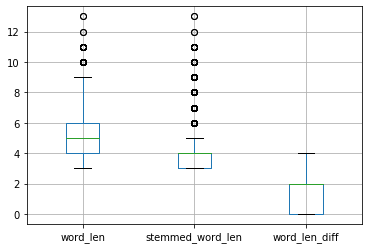

In [85]:
u4.boxplot()

In [89]:
idx = u4.word_len_diff>=5
print(idx.sum())

u4[idx].sort_values(by='word_len_diff',ascending=False)

0


,stemmed_word,word_len,stemmed_word_len,word_len_diff
word,,,,


In [90]:
idx = u4.word_len_diff==4
print(idx.sum())

u4[idx].sort_values(by='word_len',ascending=True).head(20)

1258


,stemmed_word,word_len,stemmed_word_len,word_len_diff
word,,,,
بالخمسة,خمس,7,3,4
طبقاتها,طبق,7,3,4
القسرية,قسر,7,3,4
وبالعكس,عكس,7,3,4
اللفظية,لفظ,7,3,4
وثانيها,ثان,7,3,4
البطلان,بطل,7,3,4
القرعات,قرع,7,3,4
المعدين,معد,7,3,4


#### Examples of stemming of  some important words

In [91]:
def foo2(w):
    print(f"\tGiven word: {w}\n\
    \tFrequency in clean corpus: {fdist_words_1[w]}\n\
    \tFrequency in stemmed corpus: {fdist_words_2[w]}\n\
    \tStemmed form of this word: {debug_word_stem_dict[w]}\n\
    \tset of clean words that are stemmed to this word: {debug_reverse_word_stem_dict[w]}\n")

In [92]:
foo2('البعد')

	Given word: البعد
    	Frequency in clean corpus: 22
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: بعد
    	set of clean words that are stemmed to this word: set()



In [93]:
foo2('بعد')

	Given word: بعد
    	Frequency in clean corpus: 0
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: 
    	set of clean words that are stemmed to this word: {'وبعده', 'بعدها', 'لبعده', 'والبعد', 'بالبعد', 'فبعده', 'البعد', 'وبعدها', 'فالبعد', 'وابعد', 'بعدهما'}



In [94]:
foo2('دساتين')

	Given word: دساتين
    	Frequency in clean corpus: 7
    	Frequency in stemmed corpus: 2
    	Stemmed form of this word: دسا
    	set of clean words that are stemmed to this word: {'دساتينه'}



In [95]:
foo2('الدساتين')

	Given word: الدساتين
    	Frequency in clean corpus: 31
    	Frequency in stemmed corpus: 31
    	Stemmed form of this word: الدساتين
    	set of clean words that are stemmed to this word: {'الدساتين'}



In [96]:
foo2('دسا')

	Given word: دسا
    	Frequency in clean corpus: 0
    	Frequency in stemmed corpus: 7
    	Stemmed form of this word: 
    	set of clean words that are stemmed to this word: {'دساتين'}



In [97]:
foo2('الله')

	Given word: الله
    	Frequency in clean corpus: 420
    	Frequency in stemmed corpus: 509
    	Stemmed form of this word: الله
    	set of clean words that are stemmed to this word: {'بالله', 'وبالله', 'الله', 'والله'}



In [98]:
foo2('والله')

	Given word: والله
    	Frequency in clean corpus: 71
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: الله
    	set of clean words that are stemmed to this word: set()



In [99]:
foo2('وبالله')

	Given word: وبالله
    	Frequency in clean corpus: 7
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: الله
    	set of clean words that are stemmed to this word: set()



In [100]:
foo2('الاول')

	Given word: الاول
    	Frequency in clean corpus: 203
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: اول
    	set of clean words that are stemmed to this word: set()



In [101]:
foo2('نغم')

	Given word: نغم
    	Frequency in clean corpus: 102
    	Frequency in stemmed corpus: 472
    	Stemmed form of this word: نغم
    	set of clean words that are stemmed to this word: {'النغمة', 'فنغمة', 'لنغمة', 'للنغمات', 'فالنغم', 'النغمات', 'بنغمة', 'والنغم', 'للنغم', 'بنغمه', 'للنغمة', 'والنغمة', 'كنغمة', 'فالنغمة', 'النغم', 'بنغمات', 'ونغمة', 'بالنغم', 'نغم'}



In [206]:
foo2('نقرات')

	Given word: نقرات
    	Frequency in clean corpus: 85
    	Frequency in stemmed corpus: 1
    	Stemmed form of this word: قرات
    	set of clean words that are stemmed to this word: {'النقراتي'}



In [207]:
foo2('نقرتين')

	Given word: نقرتين
    	Frequency in clean corpus: 52
    	Frequency in stemmed corpus: 0
    	Stemmed form of this word: قرتي
    	set of clean words that are stemmed to this word: set()



In [211]:
foo2('نقرة')

	Given word: نقرة
    	Frequency in clean corpus: 65
    	Frequency in stemmed corpus: 65
    	Stemmed form of this word: نقرة
    	set of clean words that are stemmed to this word: {'نقرة'}



In [210]:
foo2('نقرت')

	Given word: نقرت
    	Frequency in clean corpus: 3
    	Frequency in stemmed corpus: 3
    	Stemmed form of this word: نقرت
    	set of clean words that are stemmed to this word: {'نقرت'}



In [216]:
[(word,freq) for word,freq in fdist_words_2.items() if 'نقر' in word]

[('نقر', 76),
 ('والنقرات', 2),
 ('نقرة', 65),
 ('النقرتين', 5),
 ('نقرت', 3),
 ('بالنقرات', 1),
 ('انقر', 1),
 ('ونقر', 1),
 ('نقره', 2),
 ('نقرات', 1),
 ('ينقر', 1)]

In [220]:
for word in fdist_words_2:
    if 'نقر' in word:
        print(word)
        print(simple_stemmer.light_stem(word))
        print(stemming_wrapper(word))
        print()

نقر
قر
نقر

والنقرات
نقر
والنقرات

نقرة
نقر
نقرة

النقرتين
نقر
النقرتين

نقرت
قرت
نقرت

بالنقرات
نقر
بالنقرات

انقر
نقر
انقر

ونقر
قر
ونقر

نقره
قر
نقره

نقرات
قرات
قرات

ينقر
نقر
ينقر



In [217]:
for word in fdist_words_2:
    if 'نقر' in word:
        foo2(word)

	Given word: نقر
    	Frequency in clean corpus: 9
    	Frequency in stemmed corpus: 76
    	Stemmed form of this word: نقر
    	set of clean words that are stemmed to this word: {'وينقر', 'ونقرة', 'فنقرة', 'بنقرتي', 'بنقرات', 'النقر', 'نقر', 'النقرة', 'للنقرات', 'والنقرة', 'النقرات', 'بنقرة', 'بالنقرة'}

	Given word: والنقرات
    	Frequency in clean corpus: 2
    	Frequency in stemmed corpus: 2
    	Stemmed form of this word: والنقرات
    	set of clean words that are stemmed to this word: {'والنقرات'}

	Given word: نقرة
    	Frequency in clean corpus: 65
    	Frequency in stemmed corpus: 65
    	Stemmed form of this word: نقرة
    	set of clean words that are stemmed to this word: {'نقرة'}

	Given word: النقرتين
    	Frequency in clean corpus: 5
    	Frequency in stemmed corpus: 5
    	Stemmed form of this word: النقرتين
    	set of clean words that are stemmed to this word: {'النقرتين'}

	Given word: نقرت
    	Frequency in clean corpus: 3
    	Frequency in stemmed corpus: 3
    	Stem

### Distribution of number of words per document

In [104]:
u = pd.Series(corpus_words_2).map(len)
u.describe()

count      39.000000
mean     1430.794872
std      1753.905914
min        51.000000
25%       330.500000
50%       846.000000
75%      1667.500000
max      9390.000000
dtype: float64

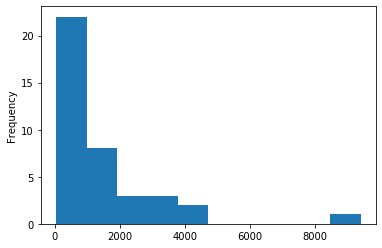

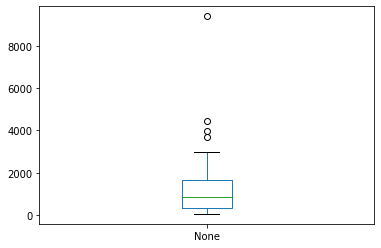

In [105]:
u.plot.hist()
plt.show()
u.plot.box()

#### very short documents

In [106]:
print((u<100).sum())
pd.DataFrame({'doc_title':doc_data_df.title_arabic[u<100],'nb_words':u[u<100]}).sort_values(by='nb_words')

4


,doc_title,nb_words
13,كتاب الامتاع والانتفاع في مسألة سماع السّماع,51
35,تلخيص كتاب النّفس,71
7,كتاب الشّفاء,87
4,كتاب الأدوار,90


#### very long documents

In [108]:
print((u>3000).sum())
pd.DataFrame({'doc_title':doc_data_df.title_arabic[u>3000],'nb_words':u[u>3000]}).sort_values(by='nb_words')

4


,doc_title,nb_words
24,رسالة القيان,3689
12,برء الأسقام، شرح القصيدة في الأنغام,3988
31,كتاب اللهو والملاهي,4431
27,العقد الفريد,9390


### Distribution of word frequency

In [109]:
fdist_words = FreqDist([tok for doc in corpus_words_2 for tok in doc])
fdist_words.N(),fdist_words.B()
print("number of words:",fdist_words.N())
print("number of distinct words:",fdist_words.B())
print('Number of distinct words that occur only once (called hapaxes):',(pd.Series(list(fdist_words.values()))==1).sum())

number of words: 55801
number of distinct words: 10851
Number of distinct words that occur only once (called hapaxes): 5566


In [111]:
print('The 20 most common words:')
fdist_words.most_common(20)

The 20 most common words:


[('قال', 615),
 ('الله', 509),
 ('نغم', 472),
 ('اول', 365),
 ('ثان', 300),
 ('فقال', 271),
 ('بيت', 217),
 ('ثلاث', 214),
 ('صوت', 202),
 ('ثقيل', 198),
 ('وكان', 195),
 ('قول', 187),
 ('علم', 185),
 ('اربع', 174),
 ('وقال', 173),
 ('دور', 171),
 ('نفس', 166),
 ('غناء', 166),
 ('رست', 165),
 ('مثن', 163)]

In [112]:
print('The 20 least common words:')
fdist_words.most_common()[-20:]

The 20 least common words:


[('ارتب', 1),
 ('حبه', 1),
 ('تهاليل', 1),
 ('مشطاطر', 1),
 ('تشطر', 1),
 ('يخدم', 1),
 ('شايب', 1),
 ('منتسب', 1),
 ('بشراف', 1),
 ('انتهائ', 1),
 ('القد', 1),
 ('خانة', 1),
 ('جركة', 1),
 ('صنايع', 1),
 ('لاكن', 1),
 ('قهار', 1),
 ('مددت', 1),
 ('ءاله', 1),
 ('بران', 1),
 ('لرصد', 1)]

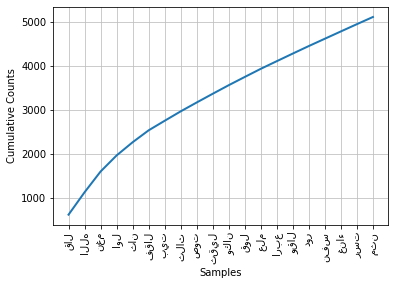

In [113]:
# the 20 most frequent words account for ~ 9% (~ 5000/55801) of all word occurrences in the corpus.

fdist_words.plot(20, cumulative=True)

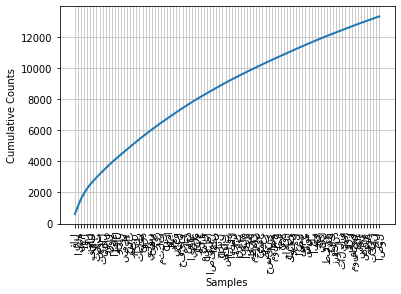

In [115]:
# the 100 most frequent words account for ~23% (~12700/55801) of all word occurrences in the corpus.

fdist_words.plot(100, cumulative=True)

In [135]:
corpus_words_df = pd.DataFrame(fdist_words.most_common(), columns=['word','frequency'])
corpus_words_df.shape

(10851, 2)

In [122]:
corpus_words_df.head()

,word,frequency
0,قال,615
1,الله,509
2,نغم,472
3,اول,365
4,ثان,300


In [123]:
corpus_words_df.describe()

,frequency
count,10851.000000
mean,5.142475
std,16.549876
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,615.000000


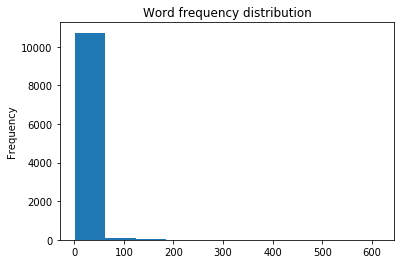

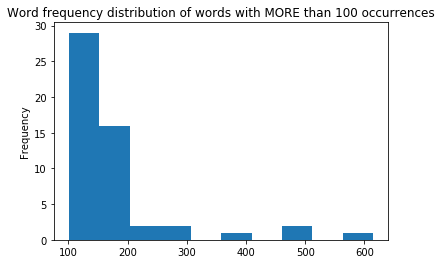

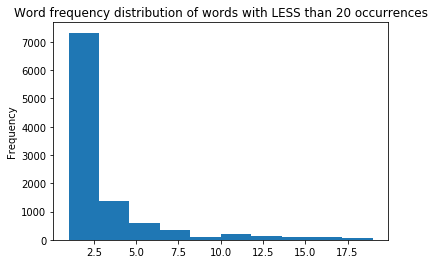

In [125]:
corpus_words_df.frequency.plot.hist()
fig1=plt.title('Word frequency distribution')
plt.show()
corpus_words_df.frequency[corpus_words_df.frequency>100].plot.hist()
fig2=plt.title('Word frequency distribution of words with MORE than 100 occurrences')
plt.show()
corpus_words_df.frequency[corpus_words_df.frequency<20].plot.hist()
fig3=plt.title('Word frequency distribution of words with LESS than 20 occurrences')

### Distribution of word length

In [136]:
corpus_words_df['word_len'] = corpus_words_df.word.map(len)
corpus_words_df.head()

,word,frequency,word_len
0,قال,615,3
1,الله,509,4
2,نغم,472,3
3,اول,365,3
4,ثان,300,3


In [137]:
corpus_words_df.describe()

,frequency,word_len
count,10851.000000,10851.000000
mean,5.142475,4.140724
std,16.549876,1.105000
min,1.000000,3.000000
25%,1.000000,4.000000
50%,1.000000,4.000000
75%,3.000000,4.000000
max,615.000000,13.000000


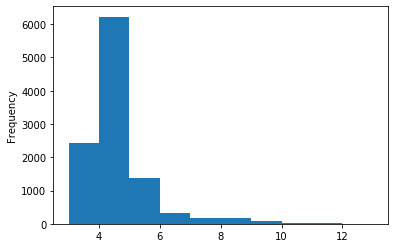

In [129]:
corpus_words_df.word_len.plot.hist()

In [145]:
idx = corpus_words_df.word_len>=9
print(idx.sum())
corpus_words_df[idx].sort_values(by='frequency',ascending=False)

126


,word,frequency,word_len
1311,والاصبهان,8,9
1698,الزيرافكند,6,10
2102,الجرادتان,5,9
2736,والترابية,3,9
2896,والاسجاحات,3,10
2988,والهوائية,3,9
3064,بالفارسية,3,9
3935,والدساتين,2,9
5277,ومقابلاتها,2,10
5272,والبراهين,2,9


### Repeated words

In [233]:
def foo3(tokens):
    prev_tok=tokens[0]
    run_len=1
    L=[]

    for tok in tokens[1:]:
        if tok==prev_tok:
            run_len+=1
        else:
            if run_len>1:
                L.append((prev_tok,run_len))
            run_len=1
        prev_tok=tok
    df=pd.DataFrame(L,columns=['word','run_length']).sort_values(by='run_length',ascending=False)
    return [(i,x) for i,x in df.word.value_counts().iteritems()]

In [235]:
u5 = pd.Series([foo3(doc_tokens) for doc_tokens in corpus_words_2])
u5.shape

(39,)

In [236]:
u5.head()

0    [(مقدم, 5), (مثن, 2), (اول, 2), (حاد, 2), (مثل...
1    [(موجود, 2), (ماخور, 2), (قرتي, 2), (نقرة, 2),...
2    [(خفيف, 2), (ماخور, 2), (قرتي, 2), (حال, 1), (...
3    [(ضعيف, 1), (سادس, 1), (اسم, 1), (فرح, 1), (حز...
4                     [(قسم, 2), (ثالث, 1), (رابع, 1)]
dtype: object

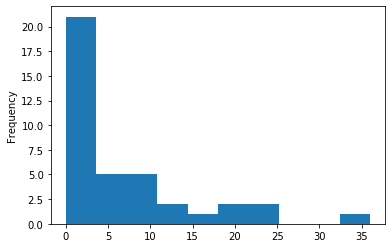

In [237]:
u5.map(len).plot.hist()

In [238]:
u5.map(len).describe()

count    39.000000
mean      6.794872
std       8.492038
min       0.000000
25%       1.000000
50%       3.000000
75%      10.000000
max      36.000000
dtype: float64

In [239]:
z = pd.DataFrame([y for x in u5.tolist() for y in x],columns=['word','frequency'])
z.shape

(265, 2)

In [240]:
z.head()

,word,frequency
0,مقدم,5
1,مثن,2
2,اول,2
3,حاد,2
4,مثلث,2


In [241]:
z.word.nunique()

217

In [242]:
sorted(z.word.unique().tolist())

['ئتلاف',
 'ابواب',
 'اجساد',
 'احسن',
 'اختيار',
 'اخر',
 'اربا',
 'ارض',
 'ازاء',
 'اسكت',
 'اسم',
 'اصبع',
 'اصل',
 'اضطرار',
 'اقرب',
 'اقوم',
 'اكرم',
 'البم',
 'الدن',
 'الف',
 'الله',
 'امسك',
 'انتا',
 'انعام',
 'انفس',
 'اود',
 'اول',
 'بدن',
 'بكي',
 'بيات',
 'بيض',
 'تاليف',
 'تبعيد',
 'تجار',
 'تراب',
 'ترك',
 'تطوي',
 'تكه',
 'تلامذ',
 'تنن',
 'ثالث',
 'ثان',
 'ثاني',
 'ثقال',
 'ثقيل',
 'ثلاث',
 'ثلث',
 'ثنتا',
 'ثنتي',
 'جانب',
 'جزء',
 'جزءا',
 'جسم',
 'جلاب',
 'جمع',
 'جنس',
 'جهة',
 'حاد',
 'حال',
 'حبيب',
 'حتبس',
 'حديث',
 'حرك',
 'حركة',
 'حزن',
 'حسن',
 'حضار',
 'حلم',
 'حمو',
 'خالد',
 'خبر',
 'ختلاف',
 'خشب',
 'خفيف',
 'خلخل',
 'خلق',
 'خمس',
 'خنصر',
 'خير',
 'دجن',
 'دخل',
 'دمع',
 'دوار',
 'دور',
 'دوكاه',
 'ذكر',
 'رابع',
 'رست',
 'رطب',
 'رفع',
 'ركب',
 'روي',
 'زرع',
 'زلزل',
 'زمان',
 'زمجر',
 'زيد',
 'زير',
 'سابع',
 'سادس',
 'سبيل',
 'ستدل',
 'سحاب',
 'سرور',
 'سكر',
 'سمع',
 'سمك',
 'سيكاه',
 'شجاع',
 'شيء',
 'شيئا',
 'شيب',
 'صاحب',
 'صام',
 'صدقت',
 '

In [244]:
z.groupby('word').agg('sum').sort_values(by='frequency',ascending=False).head(10)

,frequency
word,
قال,14
قرتي,11
نغمة,5
مقدم,5
نغم,5
وتر,5
ماخور,4
رست,4
قسم,3


### Frequency of occurrence of special terms in documents

In [245]:
from sklearn.feature_extraction.text import CountVectorizer

In [246]:
len(corpus_words_str),len(special_words_clean)

(39, 18)

In [247]:
corpus_words_str = [' '.join(doc_tokens) for doc_tokens in corpus_words_2]
len(corpus_words_str)

39

In [248]:
special_vec = CountVectorizer(vocabulary=special_words_clean)

doc_special_vocab_mat = special_vec.fit_transform(corpus_words_str)
doc_special_vocab_mat.shape

(39, 18)

In [249]:
doc_special_vocab_mat.min(),doc_special_vocab_mat.max()

(0, 42)

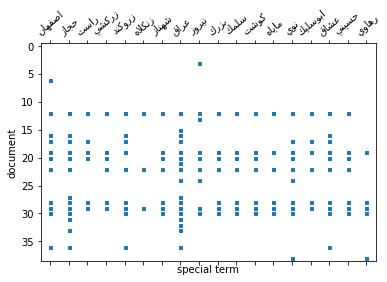

In [250]:
reshaped_special_vocab = [get_display(arabic_reshaper.reshape(word)) for word in special_words_clean]

plt.spy(doc_special_vocab_mat,precision=0, markersize=3, aspect='auto')
plt.xlabel('special term')
plt.ylabel('document')
#plt.title('Number of occurrences of special terms in documents')
fig=plt.xticks(list(range(len(special_words_clean))), reshaped_special_vocab, rotation=40)

In [251]:
doc_special_vocab_df = pd.DataFrame(doc_special_vocab_mat.A, columns=special_words_clean, index=doc_data_df.title_arabic)
doc_special_vocab_df.shape

(39, 18)

In [252]:
doc_special_vocab_df.index = doc_special_vocab_df.index.map(lambda x: x[0:50])

In [253]:
doc_special_vocab_df.head()

,اصفهان,حجاز,راست,زركشي,زروكند,زنكلاه,شهناز,عراق,نيروز,بزرك,سلمك,كوشت,ماياه,نوي,ابوسليك,عشاق,حسيني,رهاوي
title_arabic,,,,,,,,,,,,,,,,,,
رسالة في خبر صناعة التّأليف,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
كتاب المصوّتات الوتريّة من ذات الوتر الواحد إلى ذا,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
رسالة في أجزاء خبريّة في الموسيقى,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
رسالة الكندي في اللّحون والنّغم,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
كتاب الأدوار,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [254]:
doc_data_df.title_arabic[19]

'كتاب الإنعام في معرفة الأنغام'

In [255]:
doc_special_vocab_df.iloc[19,:]

اصفهان      6
حجاز        2
راست       22
زركشي       2
زروكند      6
زنكلاه      0
شهناز       2
عراق        6
نيروز       2
بزرك        3
سلمك        2
كوشت        2
ماياه       1
نوي         3
ابوسليك     1
عشاق        3
حسيني       2
رهاوي       2
Name: كتاب الإنعام في معرفة الأنغام, dtype: int64

In [256]:
## Total frequency of special terms

doc_special_vocab_df.sum(axis=0).sort_values(ascending=False)

عراق       130
حجاز       123
عشاق       115
اصفهان     113
حسيني       93
نوي         82
زروكند      77
بزرك        69
نيروز       58
ابوسليك     45
زركشي       44
راست        38
سلمك        37
ماياه       37
كوشت        34
شهناز       30
رهاوي       27
زنكلاه       6
dtype: int64

In [257]:
## Document frequency of special terms

(doc_special_vocab_df>0).sum(axis=0).sort_values(ascending=False)

عراق       17
حجاز       13
اصفهان     11
عشاق       10
نوي        10
زروكند      9
نيروز       9
سلمك        7
بزرك        7
حسيني       7
كوشت        7
شهناز       7
ماياه       6
زركشي       6
راست        6
ابوسليك     6
رهاوي       5
زنكلاه      3
dtype: int64

In [258]:
sum([('زنكلاه' in doc_tokens) for doc_tokens in corpus_words_2])

3

In [259]:
## Number of special terms per document

doc_special_vocab_df.sum(axis=1).sort_values(ascending=False)

title_arabic
برء الأسقام، شرح القصيدة في الأنغام                   319
كتاب في علم الموسيقى ومعرفة الانغام                   290
أرجوزة في الأنغام                                     156
مقدّمة في قوانين الأنغام                              140
رسالة الكشّاف في علم الأنغام / مقدّمة في علم الموس     81
كتاب الإنعام في معرفة الأنغام                          67
فنّ الأنغام                                            41
رسالة في التّعريف ببعض كلمات فارسيّة وردت في تأليف     12
العقد الفريد                                           12
المواهب الخيريّة في كيفيّة عمل البردة البصيريّة        10
نظم شجرة الطّبوع والطّبائع                              9
إيقاد الشّموع للذّة المسموع بنغمات الطبوع               5
كتاب اللهو والملاهي                                     4
رسالة القيان                                            4
المقدّمة : صناعة الغناء                                 2
كتاب الامتاع والانتفاع في مسألة سماع السّماع            1
رسالة الكندي في اللّحون والنّغم                         1
ك

In [260]:
## Number of documents that contain 0 special terms

sum((doc_special_vocab_df.sum(axis=1)==0).ravel())

18

Text(138.7707142857143, 0.5, 'document title')

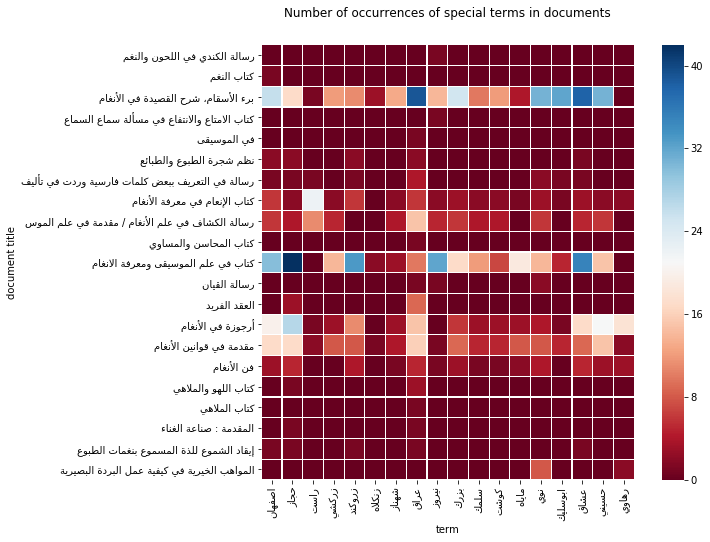

In [261]:
## Visualize matrix as a heatmap

doc_special_vocab_df2 = doc_special_vocab_df.loc[doc_special_vocab_df.sum(axis=1)>0,:].copy()
doc_special_vocab_df2.index = doc_special_vocab_df2.index.map(lambda word: get_display(arabic_reshaper.reshape(word)))
doc_special_vocab_df2.columns = reshaped_special_vocab

plt.figure(figsize=(10,8))
plt.title('Number of occurrences of special terms in documents', y=1.05, size=12)
sns.heatmap(doc_special_vocab_df2, linewidths=0.1, square=True, linecolor='white', annot=False, cmap=plt.cm.RdBu)
plt.xlabel('term')
plt.ylabel('document title')

Text(138.7707142857143, 0.5, 'document title')

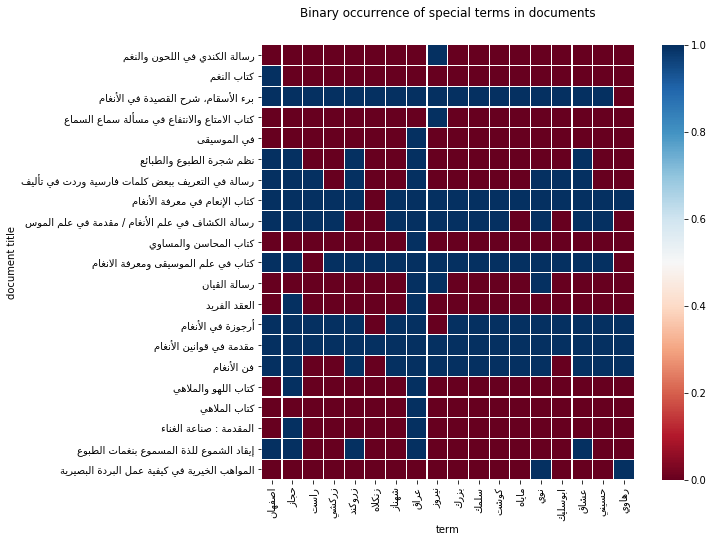

In [262]:
plt.figure(figsize=(10,8))
plt.title('Binary occurrence of special terms in documents', y=1.05, size=12)
sns.heatmap(doc_special_vocab_df2>0, linewidths=0.1, square=True, linecolor='white', annot=False, cmap=plt.cm.RdBu)
plt.xlabel('term')
plt.ylabel('document title')

***

### Remarks and conclusions

- nearly 51% (5566/10851) of words **occur only once** in the entire corpus; these words are formally called *hapaxes*. Good stemming generally helps reduce the number of hapaxes.
- very long words are either words that should've been stemmed OR named entities OR spelling errors.
- word frequency distribution of this corpus seems to follow a z-distribution, which is typical.
- there are various types of stemming errors, which we might be able to reduce by introducing more intelligent heuristics (for example by leveraging orthographic similarity) and corpus-specific heuristics.

******